## Explore SYNTHEA data in the OMOP schema 

## Develop our cohort

In [2]:
#import all the packages
import psycopg2
import pandas as pd
from getpass import getpass
from sqlalchemy import create_engine
import seaborn as sns
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

In [3]:
hostname = "spinup-db001ec7.cluster-c9ukc6s0rmbg.us-east-1.rds.amazonaws.com"
username = "introml568"
password = "m7bxMRtyMqPbcxyRRGML8"
database_name = "mimic"

In [4]:
alchemy_engine = create_engine(f"postgresql+psycopg2://{username}:{password}@{hostname}/{database_name}",  pool_recycle=3600)
db_connection = alchemy_engine.connect();

In [5]:
omop_person = pd.read_sql("select * from omop.person", db_connection);
omop_visit = pd.read_sql("select * from omop.visit_occurrence", db_connection);

In [6]:
omop_visit.head()

,visit_occurrence_id,person_id,visit_concept_id,visit_start_date,visit_start_datetime,visit_end_date,visit_end_datetime,visit_type_concept_id,provider_id,care_site_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id,admitting_concept_id,discharge_to_source_concept_id
0,213,392776072,9201,2138-07-17,2138-07-17 19:04:00,2138-07-21,2138-07-21 15:48:00,44818518,None,397812313,NEWBORN,2001047001,2001046997,PHYS REFERRAL/NORMAL DELI,8536,HOME,NaN,8940,2001051946
1,214,392776073,262,2101-10-20,2101-10-20 17:09:00,2101-10-31,2101-10-31 13:58:00,44818518,None,397812313,EMERGENCY,2001047000,2001046993,EMERGENCY ROOM ADMIT,8863,SNF,NaN,8870,2001051954
2,215,392776074,262,2191-03-15,2191-03-15 13:10:00,2191-03-23,2191-03-23 18:41:00,44818518,None,397812313,EMERGENCY,2001047000,2001046993,EMERGENCY ROOM ADMIT,8536,HOME WITH HOME IV PROVIDR,NaN,8870,2001051948
3,216,392776075,9201,2103-02-02,2103-02-02 04:31:00,2103-02-04,2103-02-04 12:15:00,44818518,None,397812313,NEWBORN,2001047001,2001046997,PHYS REFERRAL/NORMAL DELI,8536,HOME,NaN,8940,2001051946
4,217,392776076,9201,2175-05-30,2175-05-30 07:15:00,2175-06-15,2175-06-15 16:00:00,44818518,None,397812313,ELECTIVE,2001046999,2001046997,PHYS REFERRAL/NORMAL DELI,8536,HOME HEALTH CARE,NaN,8940,2001051947


## Start to derive required columns

In [5]:
def person_age(birthdate):
    """
    defines age based on current date
    """
    difference_in_years = relativedelta(datetime.now(), birthdate).years
    return difference_in_years

omop_person['current_age'] = omop_person.birth_datetime.apply(person_age)

In [6]:
#inner join two tables
df = pd.merge(omop_person, omop_visit, on='person_id', how="inner")
col_keep = ['person_id', 'visit_occurrence_id', 'visit_start_date', 'visit_end_date', 'visit_start_datetime','visit_end_datetime', 'birth_datetime', 'current_age',
            'gender_source_value', 'race_source_value', 'ethnicity_source_value']
df = df[col_keep]

In [7]:
df['age_at_visit'] = df.apply(lambda x: relativedelta(x['visit_start_datetime'], x['birth_datetime']).years, axis=1)
df['visit_length'] = df.apply(lambda x: relativedelta(x['visit_end_datetime'], x['visit_start_datetime']).hours, axis=1)
df.rename(columns={'gender_source_value': 'gender_concept_ID', 'race_source_value': 'race', 'ethnicity_source_value': 'ethnicity'}, inplace=True)
df.head(10)

,person_id,visit_occurrence_id,visit_start_date,visit_end_date,visit_start_datetime,visit_end_datetime,birth_datetime,current_age,gender_concept_ID,race,ethnicity,age_at_visit,visit_length
0,1,63,1928-05-07,1928-05-07,1928-05-07,1928-05-07,1927-10-03,96,F,white,nonhispanic,0,0
1,1,53,1928-05-18,1928-05-18,1928-05-18,1928-05-18,1927-10-03,96,F,white,nonhispanic,0,0
2,1,73,1945-11-26,1945-11-26,1945-11-26,1945-11-26,1927-10-03,96,F,white,nonhispanic,18,0
3,1,48,1946-12-02,1946-12-02,1946-12-02,1946-12-02,1927-10-03,96,F,white,nonhispanic,19,0
4,1,55,1947-12-08,1947-12-08,1947-12-08,1947-12-08,1927-10-03,96,F,white,nonhispanic,20,0
5,1,61,1948-12-13,1948-12-13,1948-12-13,1948-12-13,1927-10-03,96,F,white,nonhispanic,21,0
6,1,19,1949-11-25,1949-11-26,1949-11-25,1949-11-26,1927-10-03,96,F,white,nonhispanic,22,0
7,1,69,1949-12-19,1949-12-19,1949-12-19,1949-12-19,1927-10-03,96,F,white,nonhispanic,22,0
8,1,60,1950-01-19,1950-01-19,1950-01-19,1950-01-19,1927-10-03,96,F,white,nonhispanic,22,0
9,1,52,1950-12-25,1950-12-25,1950-12-25,1950-12-25,1927-10-03,96,F,white,nonhispanic,23,0


## Inclusion Criteria

In [8]:
#people alive
death = pd.read_sql("select * from omop.death", db_connection);
df_alive = df[~df['person_id'].isin(death['person_id'])]

In [9]:
#filter age 52 - 56
df_age = df_alive[(df_alive['current_age'] >= 52) & (df_alive['current_age'] <= 56)]

In [10]:
df_sorted = df_age.sort_values(by=['person_id', 'visit_start_date'])
df_limited_visits = df_sorted.groupby('person_id').head(37)

## Combine Conditioning and Measurement with concept

In [11]:
omop_meas = pd.read_sql("select * from omop.measurement", db_connection);
omop_concept = pd.read_sql("select * from omop.concept", db_connection);
omop_condition = pd.read_sql("select * from omop.condition_occurrence", db_connection);

In [12]:
#condition - hypertension
df_condition = pd.merge(omop_condition, omop_concept[['concept_id', 'concept_name']], left_on='condition_concept_id', right_on='concept_id')

In [13]:
hypertension_concepts = df_condition[df_condition['concept_name'].str.contains('hypertension', case=False, na=False)]
df_merge = pd.merge(df_limited_visits, hypertension_concepts[['person_id', 'concept_name']], 
                     on='person_id', 
                     how='left')
df_merge['condition - hypertension'] = df_merge['concept_name'].apply(lambda x: 'Presence' if pd.notnull(x) and 'hypertension' in x.lower() else 'Absence')

In [14]:
diabetes_concepts = df_condition[df_condition['concept_name'].str.contains('diabetes', case=False, na=False)]
merged_df = pd.merge(df_merge, diabetes_concepts[['person_id', 'concept_name']], 
                     on='person_id', 
                     how='inner')
df_merge['condition - diabetes'] = df_merge['concept_name'].apply(lambda x: 'Presence' if pd.notnull(x) and 'diabetes' in x.lower() else 'Absence')

In [15]:
df_merge.head(10)

,person_id,visit_occurrence_id,visit_start_date,visit_end_date,visit_start_datetime,visit_end_datetime,birth_datetime,current_age,gender_concept_ID,race,ethnicity,age_at_visit,visit_length,concept_name,condition - hypertension,condition - diabetes
0,12,551,1981-06-03,1981-06-03,1981-06-03,1981-06-03,1968-05-08,55,M,white,nonhispanic,13,0,Essential hypertension,Presence,Absence
1,12,548,1987-07-08,1987-07-08,1987-07-08,1987-07-08,1968-05-08,55,M,white,nonhispanic,19,0,Essential hypertension,Presence,Absence
2,12,557,1988-07-13,1988-07-13,1988-07-13,1988-07-13,1968-05-08,55,M,white,nonhispanic,20,0,Essential hypertension,Presence,Absence
3,12,543,1989-07-19,1989-07-19,1989-07-19,1989-07-19,1968-05-08,55,M,white,nonhispanic,21,0,Essential hypertension,Presence,Absence
4,12,561,1990-07-25,1990-07-25,1990-07-25,1990-07-25,1968-05-08,55,M,white,nonhispanic,22,0,Essential hypertension,Presence,Absence
5,12,572,1991-07-31,1991-07-31,1991-07-31,1991-07-31,1968-05-08,55,M,white,nonhispanic,23,0,Essential hypertension,Presence,Absence
6,12,559,1992-08-05,1992-08-05,1992-08-05,1992-08-05,1968-05-08,55,M,white,nonhispanic,24,0,Essential hypertension,Presence,Absence
7,12,564,1993-08-11,1993-08-11,1993-08-11,1993-08-11,1968-05-08,55,M,white,nonhispanic,25,0,Essential hypertension,Presence,Absence
8,12,577,1994-08-17,1994-08-17,1994-08-17,1994-08-17,1968-05-08,55,M,white,nonhispanic,26,0,Essential hypertension,Presence,Absence
9,12,568,1995-08-23,1995-08-23,1995-08-23,1995-08-23,1968-05-08,55,M,white,nonhispanic,27,0,Essential hypertension,Presence,Absence


In [16]:
#including measure #1
df_meas = pd.merge(omop_meas, omop_concept[['concept_id', 'concept_name']], left_on='measurement_concept_id', right_on='concept_id')
meas_keep = ['visit_occurrence_id', 'concept_name', 'value_source_value']
df_meas = df_meas[meas_keep]

In [17]:
aggregated_df = df_meas.groupby(['visit_occurrence_id', 'concept_name']).agg(
    aggregated_value=('value_source_value', 'sum')  # or 'sum', 'max', etc.
).reset_index()

In [18]:
pivot_df = aggregated_df.pivot(index='visit_occurrence_id', columns='concept_name', values='aggregated_value')

In [19]:
pivot_df_reset = pivot_df.reset_index()

In [20]:
df_merged = pd.merge(df_merge, pivot_df_reset, 
                           on='visit_occurrence_id', 
                           how='left')

In [21]:
df_merged.head(10)

,person_id,visit_occurrence_id,visit_start_date,visit_end_date,visit_start_datetime,visit_end_datetime,birth_datetime,current_age,gender_concept_ID,race,...,Urine protein measurement,Urine screening for glucose,Urine screening test for diabetes,Walnut IgE Ab [Units/volume] in Serum,Weight difference [Mass difference] --pre dialysis - post dialysis,Weight-for-length Per age and sex,Wheat IgE Ab [Units/volume] in Serum,White Oak IgE Ab [Units/volume] in Serum,pH of Arterial blood,pH of Urine by Test strip
0,12,551,1981-06-03,1981-06-03,1981-06-03,1981-06-03,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12,548,1987-07-08,1987-07-08,1987-07-08,1987-07-08,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12,557,1988-07-13,1988-07-13,1988-07-13,1988-07-13,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12,543,1989-07-19,1989-07-19,1989-07-19,1989-07-19,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12,561,1990-07-25,1990-07-25,1990-07-25,1990-07-25,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,12,572,1991-07-31,1991-07-31,1991-07-31,1991-07-31,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,12,559,1992-08-05,1992-08-05,1992-08-05,1992-08-05,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,12,564,1993-08-11,1993-08-11,1993-08-11,1993-08-11,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,12,577,1994-08-17,1994-08-17,1994-08-17,1994-08-17,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,12,568,1995-08-23,1995-08-23,1995-08-23,1995-08-23,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exclusion criteria

In [38]:
df_merged['Systolic blood pressure'] = pd.to_numeric(df_merged['Systolic blood pressure'], errors='coerce')
df_visit = df_merged.sort_values(by=['person_id', 'visit_start_date'])
df_visit['visit_number'] = df_visit.groupby('person_id').cumcount() + 1
condition = ~((df_visit['visit_number'].between(3, 17)) & (df_visit['Systolic blood pressure'] >= 140))
exclusive1_df = df_visit[condition]

In [39]:
#remove rows with all nan in the dataframe
selected_columns = df_merged.columns[16:]
all_nan_rows = df_merged[df_merged[selected_columns].isna().all(axis=1)]
clean_df = exclusive1_df.drop(all_nan_rows.index)

In [40]:
clean_df.drop(columns=['visit_start_date', 'visit_end_date', 'visit_start_datetime', 'visit_end_datetime', 'birth_datetime', 'concept_name', 'visit_number'], inplace=True)

In [41]:
clean_df.fillna('NA', inplace=True)
clean_df.to_csv('dat.csv', index=False)

In [42]:
len(clean_df)

6518

##Visualization

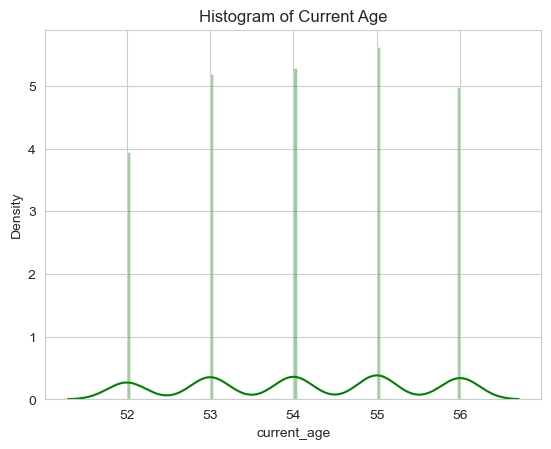

In [43]:
# create histogram for current_age
sns.distplot(clean_df['current_age'], color='g', bins=100, hist_kws={'alpha': 0.4});
plt.title('Histogram of Current Age');
plt.show()

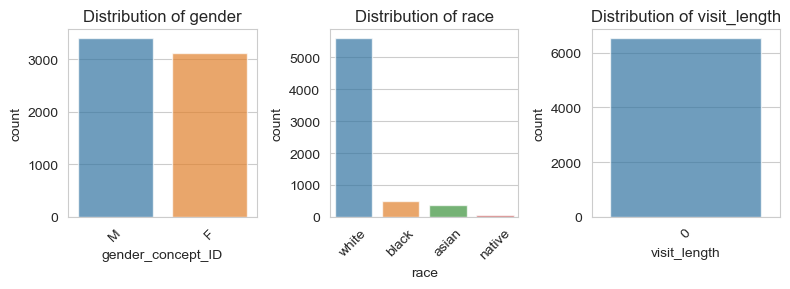

In [44]:
#create bar plot for gender, race and visit_length
cat_col = ['gender_concept_ID', 'race', 'visit_length']
df_cat = clean_df[cat_col]

fig, axes = plt.subplots(1, 3, figsize=(8, 3))
titles = ['Distribution of gender', 'Distribution of race', 'Distribution of visit_length']

for i, ax in enumerate(fig.axes):
    if i < len(df_cat.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_cat.columns[i], alpha=0.7, data=df_cat, ax=ax)
        ax.set_title(titles[i])

fig.tight_layout()

## making Box-Plot

In [45]:
select_columns = df_merged.columns[16:]
all_nan_row = df_merged[df_merged[selected_columns].isna().all(axis=1)]
box_plot_df = exclusive1_df.drop(all_nan_row.index)

In [46]:
box_df = pd.merge(box_plot_df, omop_visit[['visit_occurrence_id', 'admitted_from_concept_id', 'discharged_to_concept_id']], on='visit_occurrence_id', how='left')
box_df = pd.merge(box_df, omop_concept[['concept_id', 'concept_name']], 
                     left_on='admitted_from_concept_id', 
                     right_on='concept_id', 
                     how='left').rename(columns={'concept_name_y': 'admitted_from'})

box_df = pd.merge(box_df, omop_concept[['concept_id', 'concept_name']], 
                     left_on='discharged_to_concept_id', 
                     right_on='concept_id', 
                     how='left').rename(columns={'concept_name': 'discharged_to'})
box_df = box_df.drop(columns=['concept_id_x', 'concept_id_y'])
box_df.head(10)

,person_id,visit_occurrence_id,visit_start_date,visit_end_date,visit_start_datetime,visit_end_datetime,birth_datetime,current_age,gender_concept_ID,race,...,Weight-for-length Per age and sex,Wheat IgE Ab [Units/volume] in Serum,White Oak IgE Ab [Units/volume] in Serum,pH of Arterial blood,pH of Urine by Test strip,visit_number,admitted_from_concept_id,discharged_to_concept_id,admitted_from,discharged_to
0,12,556,2012-11-28,2012-11-28,2012-11-28,2012-11-28,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,28,0,0,No matching concept,No matching concept
1,12,555,2013-12-04,2013-12-04,2013-12-04,2013-12-04,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,29,0,0,No matching concept,No matching concept
2,12,570,2014-12-10,2014-12-10,2014-12-10,2014-12-10,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,30,0,0,No matching concept,No matching concept
3,12,576,2015-12-16,2015-12-16,2015-12-16,2015-12-16,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,31,0,0,No matching concept,No matching concept
4,12,549,2016-12-21,2016-12-21,2016-12-21,2016-12-21,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,33,0,0,No matching concept,No matching concept
5,12,550,2017-12-27,2017-12-27,2017-12-27,2017-12-27,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,34,0,0,No matching concept,No matching concept
6,12,560,2019-01-02,2019-01-02,2019-01-02,2019-01-02,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,36,0,0,No matching concept,No matching concept
7,12,566,2020-01-08,2020-01-08,2020-01-08,2020-01-08,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,37,0,0,No matching concept,No matching concept
8,18,817,2012-12-03,2012-12-03,2012-12-03,2012-12-03,1968-11-18,54,M,white,...,NaN,NaN,NaN,NaN,NaN,3,0,0,No matching concept,No matching concept
9,18,825,2014-02-05,2014-02-05,2014-02-05,2014-02-05,1968-11-18,54,M,white,...,NaN,NaN,NaN,NaN,NaN,4,0,0,No matching concept,No matching concept


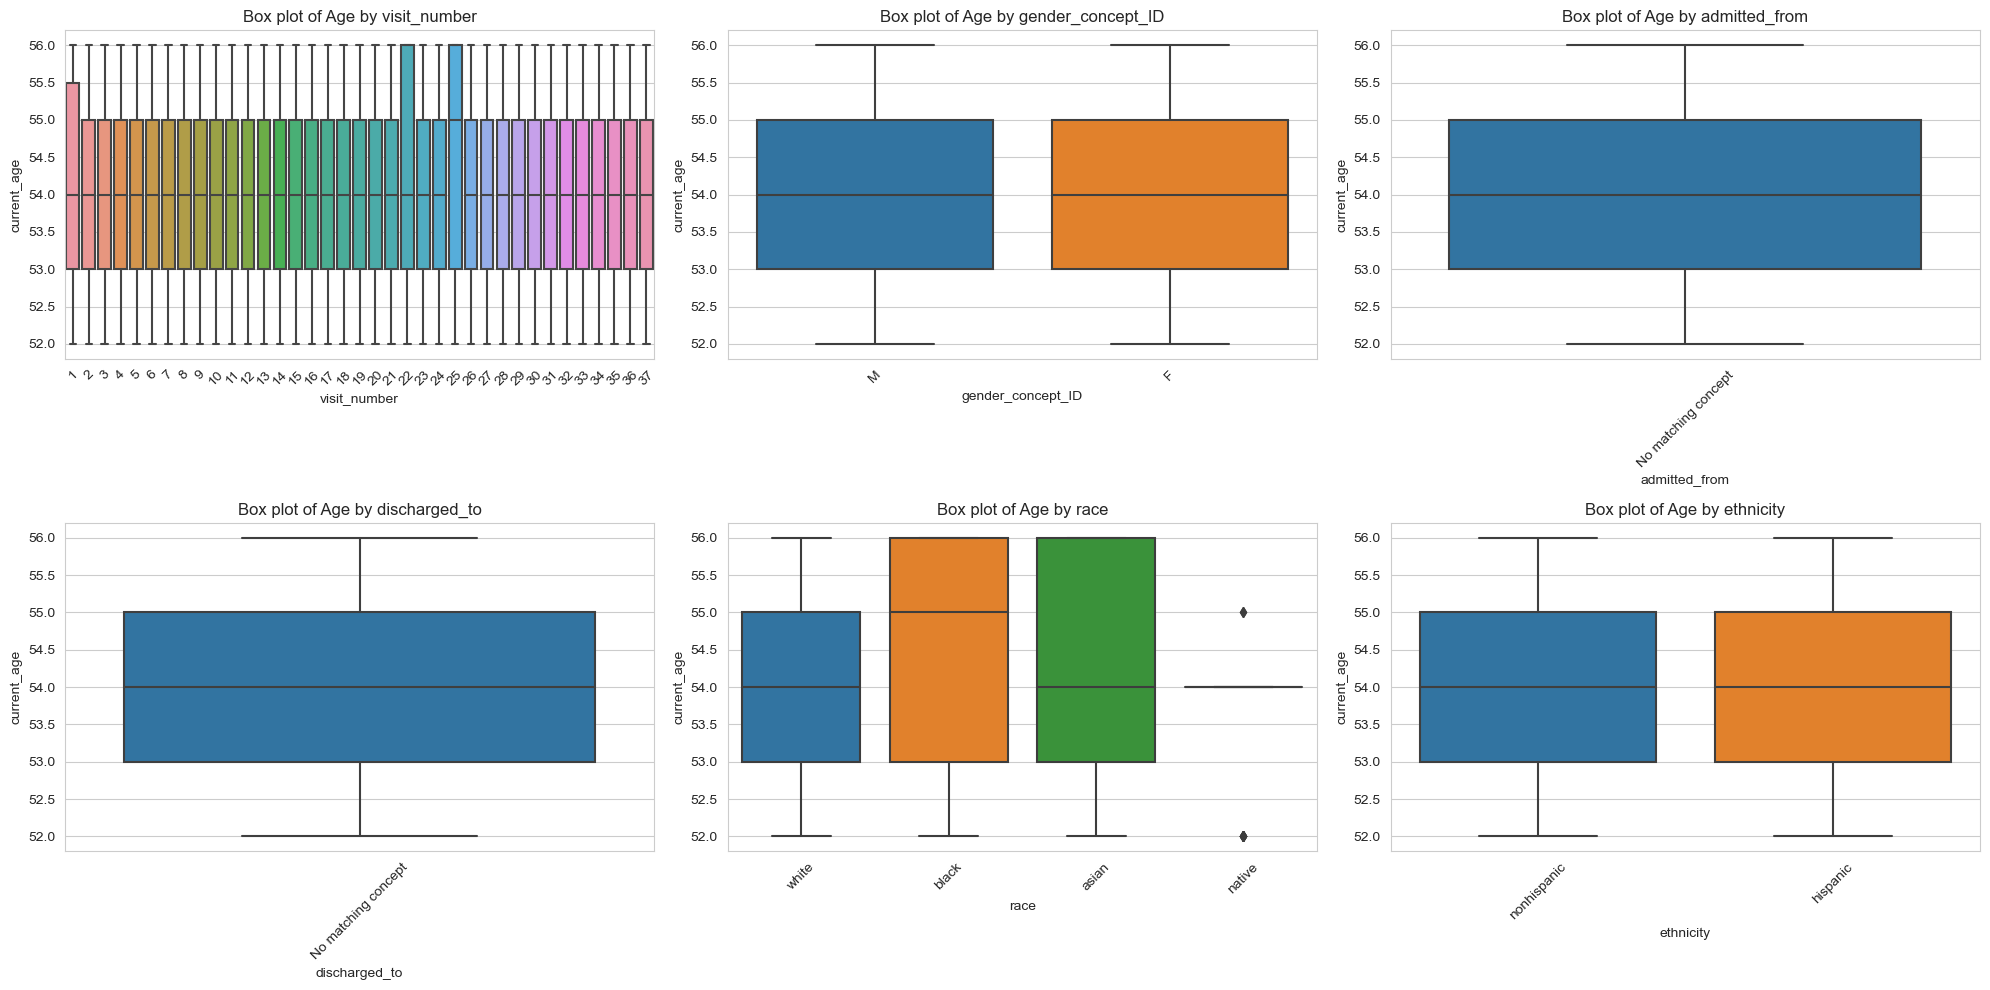

In [47]:
cat_cols = ['visit_number', 'gender_concept_ID', 'admitted_from', 'discharged_to', 'race', 'ethnicity']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axes = axes.flatten()
for i, cat in enumerate(cat_cols):
    ax = sns.boxplot(x=cat, y='current_age', data=box_df, ax=axes[i])
    ax.set_title(f'Box plot of Age by {cat}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
fig.tight_layout()
plt.show()